In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from missingno import matrix 
import datetime

In [2]:
url_minute_flow_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Drainage data/drainage_data_minute.csv'
df_flow_minute = pd.read_csv(url_minute_flow_data)


url_minute_height_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Drainage data/drainage_height_data_minute.csv'
df_height_minute = pd.read_csv(url_minute_height_data)


In [21]:
# flow_sensor,height_sensor,best_A,areas = 'F-RVK-BOD-RS111','F-RVK-BOD-HS111',500,np.arange(0,1000,10)
flow_sensor,height_sensor,best_A,areas = 'F-RVK-GEL-RS901','F-RVK-GEL-HS111',5000,np.arange(0,10000,100)


df_BOD = df_flow_minute.loc[df_flow_minute.Name == flow_sensor,].copy()
df_BOD.CTime = pd.to_datetime(df_BOD.CTime)
dates = df_BOD.loc[:,'CTime'].copy()
df_BOD = df_BOD.drop('CTime',axis=1)
df_BOD.index = dates
df_BOD.head(2)

f = df_BOD.loc[:,'Val']
f_flags = df_BOD.loc[:,'Flag']
f = f[f_flags == 0]
f = f.resample('60s').mean().interpolate()


df_BOD = df_height_minute.loc[df_height_minute.Name == height_sensor,].copy()
df_BOD = df_BOD[df_BOD.CType == 4]
df_BOD.CTime = pd.to_datetime(df_BOD.CTime)
dates = df_BOD.loc[:,'CTime'].copy()
df_BOD = df_BOD.drop('CTime',axis=1)
df_BOD.index = dates
df_BOD.head(2)

h = df_BOD.loc[:,'Val']
h_flags = df_BOD.loc[:,'Flag']
h = h[h_flags == 0]
h = h.resample('60s').mean().interpolate()

5000 -1.1741088774604242


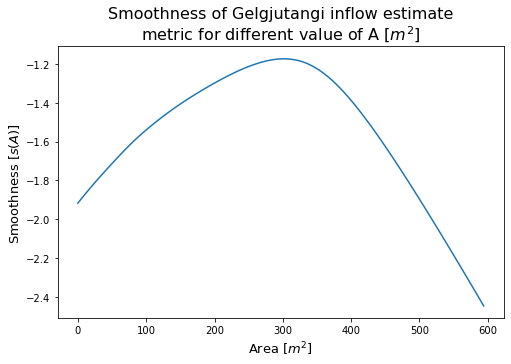

In [22]:

smoothness = lambda x : np.nanmean(np.abs(np.diff(x)))

smoothness_list = []
n_roll = 90
for area in areas:
    f_re = f.rolling(n_roll).mean() + h.diff().rolling(n_roll).mean() .shift(0)*area
    sm = -1*smoothness(f_re)
    smoothness_list.append(sm)

plt.figure(figsize=(8,5))
plt.plot(areas * 3.6 /60,smoothness_list)
plt.ylabel('Smoothness $[s(A)]$',fontsize=13)
plt.xlabel('Area $[m^2]$',fontsize=13)
plt.title('Smoothness of Gelgjutangi inflow estimate\nmetric for different value of A $[m^2]$',fontsize=16)
# plt.title('Smoothness of Boðagrandi inflow estimate\nmetric for different value of A $[m^2]$',fontsize=16)
print(areas[np.argmax(smoothness_list)],np.max(smoothness_list))
# best_A = areas[np.argmax(smoothness_list)]

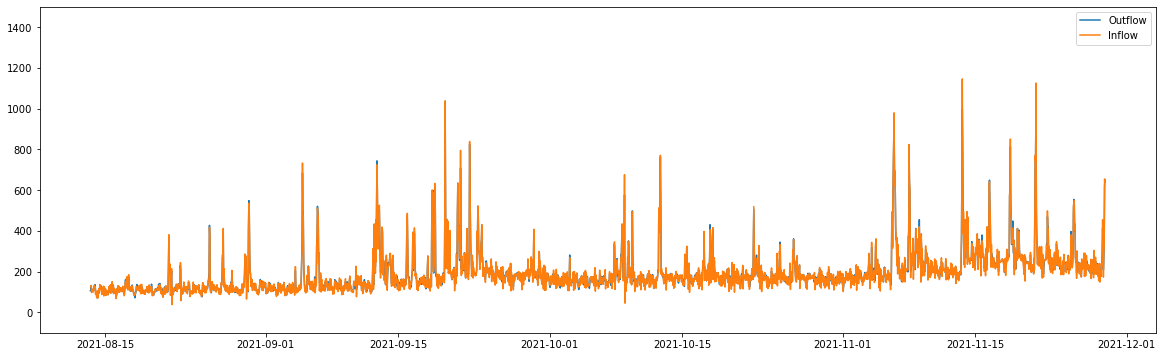

Mean flow: 193.44421726415422
Max flow: 1145.4136541280577
Min flow: 37.95948476230558
mean absolute error: 12.117540237316225
Max overestimate: -125.43095008255045
Max underestimate: 148.2607321836133


In [23]:
hourly_change_in_waterlevel = h.loc['2021-08-13 11:00:00':].resample('60s').mean().iloc[::60].diff()
# hourly_change_in_waterlevel = h.loc['2021-08-13 11:00:00':].resample('60s').mean().diff()
# hourly_difference_between_input_and_output_flow = hourly_change_in_waterlevel*5000
hourly_difference_between_input_and_output_flow = hourly_change_in_waterlevel*best_A

hourly_average_flow_rate = f.loc['2021-08-13 11:00:00':].resample('60s').mean().resample('1h').mean()
# hourly_average_flow_rate = f.loc['2021-08-13 11:00:00':].resample('60s').mean()

f1 = hourly_average_flow_rate
f2 = hourly_average_flow_rate + hourly_difference_between_input_and_output_flow/60
fig = plt.figure(figsize=(20,6))
n_roll = 1
plt.plot(f1)
plt.plot(f2)
tmp_start,tmp_end = datetime.datetime(2021,11,1),datetime.datetime(2021,11,10)
# plt.xlim(tmp_start,tmp_end)
plt.ylim(-100,1500)
plt.legend(['Outflow','Inflow'])
plt.show()

resids = f2-f1
print('Mean flow:',f2.mean())
print('Max flow:',f2.max())
print('Min flow:',f2.min())
print('mean absolute error:',np.abs(resids).mean())
print('Max overestimate:',resids.min())
print('Max underestimate:',resids.max())

In [24]:
1.2117540237316227

1.2117540237316227

In [25]:
# plt.hist(resids,bins = np.arange(-10,10,0.5))

In [26]:
manual_stats_dict_list = [{
    'Pumping station':'Boðagrandi',
    'Start of period':'2021-08-13 01:00:00',
    'End of period':'2021-12-28 23:00:00',
    'Mean flow':'61.84 [l/s]',
    'Max flow':'193.74 [l/s]',
    'Min flow':'13.16 [l/s]',
    'Mean absolute difference':'1.88 [l/s]',
    'Max overestimate':'9.28 [l/s]',
    'Max undersetimate':'8.79 [l/s]',

},
                          
                          {
    
    'Pumping station':'Gelgjutangi',
    'Start of period':'2021-08-13 01:00:00',
    'End of period':'2021-12-28 23:00:00',
    'Mean flow':'193.44 [l/s]',
    'Max flow':'1145.41 [l/s]',
    'Min flow':'37.96 [l/s]',
    'Mean absolute difference':'12.12 [l/s]',
    'Max overestimate':'125.43 [l/s]',
    'Max undersetimate':'148.26 [l/s]',
}]

df_table = pd.DataFrame(manual_stats_dict_list).T
# print(df_latex)

df_table.columns = df_table.iloc[0,:]
df_table = df_table.drop('Pumping station',axis=0)
df_latex = df_table.to_latex(label='tab:FlowDiff',)
print(df_latex)

\begin{table}
\centering
\label{fig:FlowDiff}
\begin{tabular}{lll}
\toprule
Pumping station &           Boðagrandi &          Gelgjutangi \\
\midrule
Start of period          &  2021-08-13 01:00:00 &  2021-08-13 01:00:00 \\
End of period            &  2021-12-28 23:00:00 &  2021-12-28 23:00:00 \\
Mean flow                &          61.84 [l/s] &         193.44 [l/s] \\
Max flow                 &         193.74 [l/s] &        1145.41 [l/s] \\
Min flow                 &          13.16 [l/s] &          37.96 [l/s] \\
Mean absolute difference &           1.88 [l/s] &          12.12 [l/s] \\
Max overestimate         &           9.28 [l/s] &         125.43 [l/s] \\
Max undersetimate        &           8.79 [l/s] &         148.26 [l/s] \\
\bottomrule
\end{tabular}
\end{table}



# plot period with largest flow difference

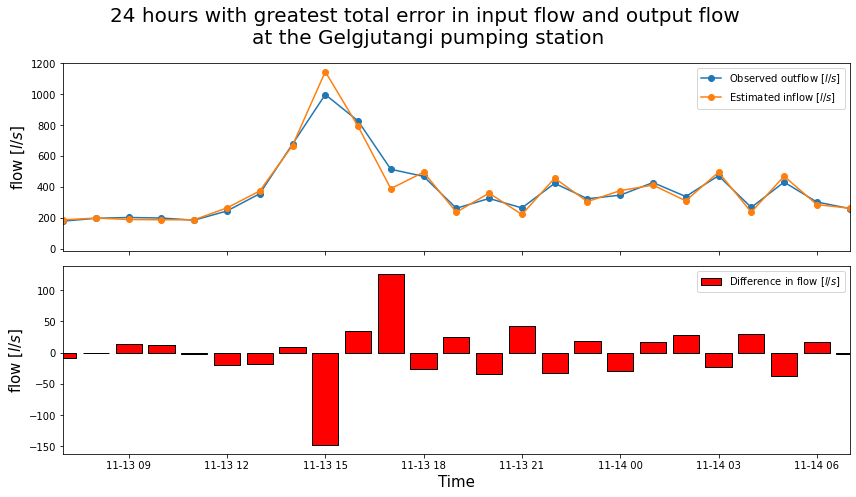

In [29]:
resids = f2-f1
# plt.figure(figsize=(10,7))
f,axes = plt.subplots(2,1,figsize = (12,7),sharex=True)
axes[0].plot(f1,marker = 'o',label='Observed outflow $[l/s]$')
axes[0].plot(f2,marker = 'o',label='Estimated inflow $[l/s]$')
axes[1].bar(f1.index, height = f1-f2, width = datetime.timedelta(hours = 0.8), label='Difference in flow $[l/s]$',color = 'red',edgecolor='black')

windows_size = 24
error_2_week_window = resids.abs().rolling(windows_size,center = True).mean()
worst_period = error_2_week_window.idxmax()
plt.xlim(worst_period - datetime.timedelta(hours = windows_size//2),
         worst_period + datetime.timedelta(hours = windows_size//2))
axes[0].legend()
axes[1].legend()


label_fontsize = 15
title_fontsize = 20
axes[0].set_ylabel('flow $[l/s]$',fontsize=label_fontsize)
axes[1].set_ylabel('flow $[l/s]$',fontsize=label_fontsize)
axes[1].set_xlabel('Time',fontsize=label_fontsize)

f.suptitle('24 hours with greatest total error in input flow and output flow \nat the Gelgjutangi pumping station',fontsize=title_fontsize)
# f.suptitle('24 hours with greatest total error in input flow and output flow \nat the Boðagrandi pumping station',fontsize=title_fontsize)
plt.tight_layout()
plt.show()

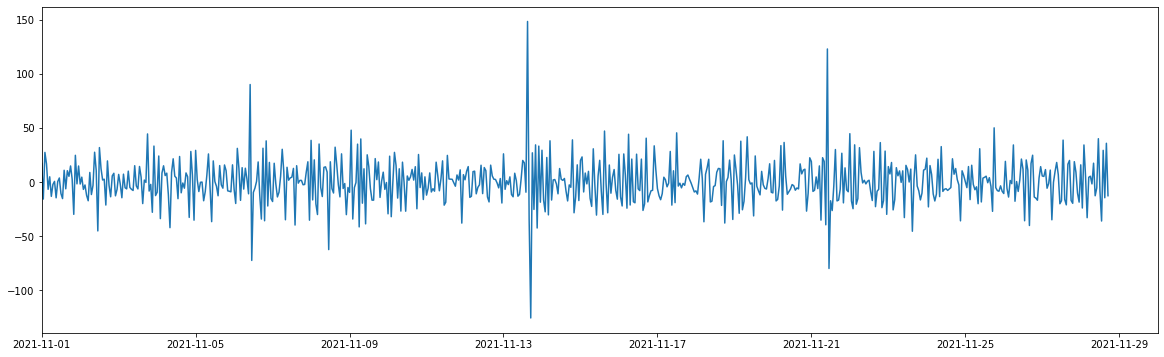

12.117540237316225


In [28]:
resids = f2-f1

fig = plt.figure(figsize=(20,6))
plt.plot(resids)

tmp_start,tmp_end = datetime.datetime(2021,11,1),datetime.datetime(2021,11,30)
plt.xlim(tmp_start,tmp_end)
plt.show()
print(np.abs(resids).mean())

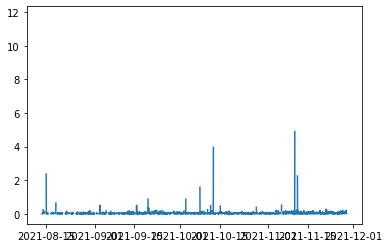

In [826]:

p_error = ((h.diff(60)*5000/60).iloc[::60].abs()/f).dropna()
plt.plot(p_error)

In [827]:
print(np.mean((h.diff(60)*5000/60).iloc[::60].abs()))
print(np.mean((h.diff(60)*5000/60).iloc[::60].abs())/np.mean(f))
print(np.max((h.diff(60)*5000/60).iloc[::60].abs()))
print(np.max((h.diff(60)*5000/60).iloc[::60].abs())/np.mean(f))

p_error = ((h.diff(60)*5000/60).iloc[::60].abs()/f).dropna()
print(np.max(p_error[p_error!=np.inf]))

print()

print(np.mean((h.diff(60)*490/60).iloc[::60].abs()))
print(np.mean((h.diff(60)*490/60).iloc[::60].abs())/np.mean(f))
print(np.max((h.diff(60)*490/60).iloc[::60].abs()))
print(np.max((h.diff(60)*490/60).iloc[::60].abs())/np.mean(f))

p_error = ((h.diff(60)*490/60).iloc[::60].abs()/f).dropna()
print(np.max(p_error[p_error!=np.inf]))

12.450588481574814
0.07511740036256667
209.9813384487278
1.266868011280188
11.750190065454458

1.2201576711943316
0.007361505235531533
20.578171167975324
0.12415306510545843
1.151518626414537


AttributeError: 'Series' object has no attribute 'dropinf'

In [768]:
df_height_minute.Quality.value_counts()

Good, Calculated                                      6556389
Good, Raw                                             6386328
Good, Raw, Extrapolated                               5231972
Not specified                                          227054
Bad, Raw, Extrapolated, Comm.failure                    14942
No data                                                  6318
Bad, Raw, Comm.failure                                     48
Bad, Calculated, No Data                                    1
Name: Quality, dtype: int64

5025.0 1.1741278426791864


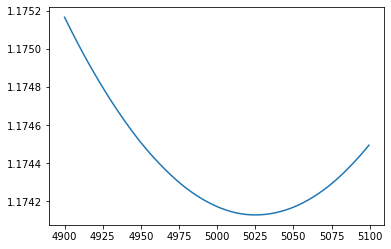

In [783]:

smoothness = lambda x : np.nanmean(np.abs(np.diff(x)))

areas = np.arange(4900,5100,0.5)
smoothness_list = []
n_roll = 90
for area in areas:
    f_re = f.rolling(n_roll).mean() + h.diff().rolling(n_roll).mean() .shift(0)*area
    sm = smoothness(f_re)
    smoothness_list.append(sm)
    
plt.plot(areas,smoothness_list)
print(areas[np.argmin(smoothness_list)],np.min(smoothness_list))

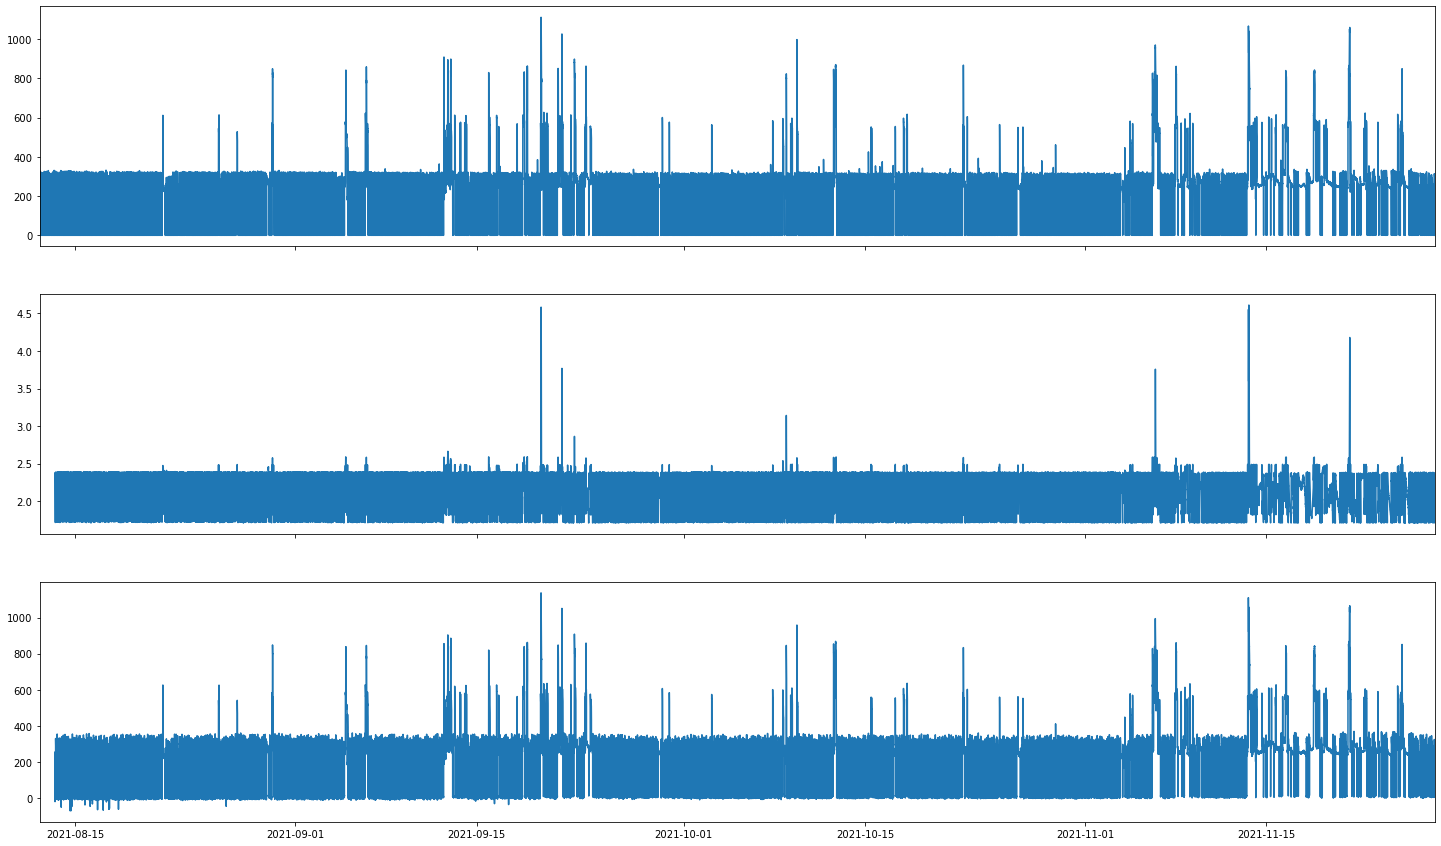

In [770]:
tmp_start,tmp_end = datetime.datetime(2021,8,12,6),datetime.datetime(2021,11,28)
fig,ax = plt.subplots(3,1,figsize=(25,15),sharex=True)
ax[0].plot(f)
ax[1].plot(h)
ax[2].plot(f + h.diff()*371.5)
plt.xlim(tmp_start,tmp_end)
# ax[2].set_ylim(-10,200)
plt.show()


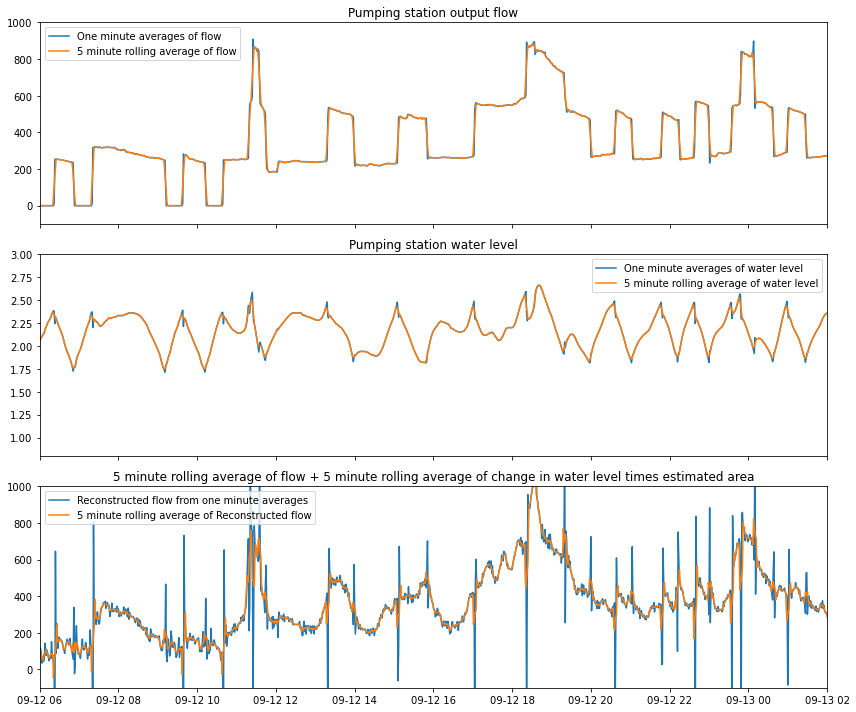

In [771]:
n_roll = 5
tmp_start,tmp_end = datetime.datetime(2021,9,12,6),datetime.datetime(2021,9,13,2)
# tmp_start,tmp_end = datetime.datetime(2021,9,12,6),datetime.datetime(2021,9,15,2)
fig,ax = plt.subplots(3,1,figsize=(12,10),sharex=True)
ax[0].plot(f,label='One minute averages of flow')
ax[0].plot(f.rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of flow')
# ax[0].set_ylim(-10,190)
ax[0].set_ylim(-100,1000)
ax[0].legend()
ax[0].set_title('Pumping station output flow')

ax[1].plot(h,label='One minute averages of water level')
ax[1].plot(h.rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of water level')
# ax[1].set_ylim(0.8,2.2)
ax[1].set_ylim(0.8,3)
ax[1].legend()
ax[1].set_title(f'Pumping station water level')

ax[2].plot(f + h.diff()*5000,label='Reconstructed flow from one minute averages')
ax[2].plot((f + h.diff()*5000).rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of Reconstructed flow')
(['Minute avergae flow',f'Minute avergae flow (rolling {n_roll})',f'Minute avergae flow (rolling {n_roll}) plus estimated change in volume (rolling {n_roll})'])
ax[2].legend()
ax[2].set_title(f'{n_roll} minute rolling average of flow + {n_roll} minute rolling average of change in water level times estimated area')
# ax[2].set_ylim(-5,210)
ax[2].set_ylim(-100,1000)
plt.xlim(tmp_start,tmp_end)
plt.tight_layout()
plt.show()


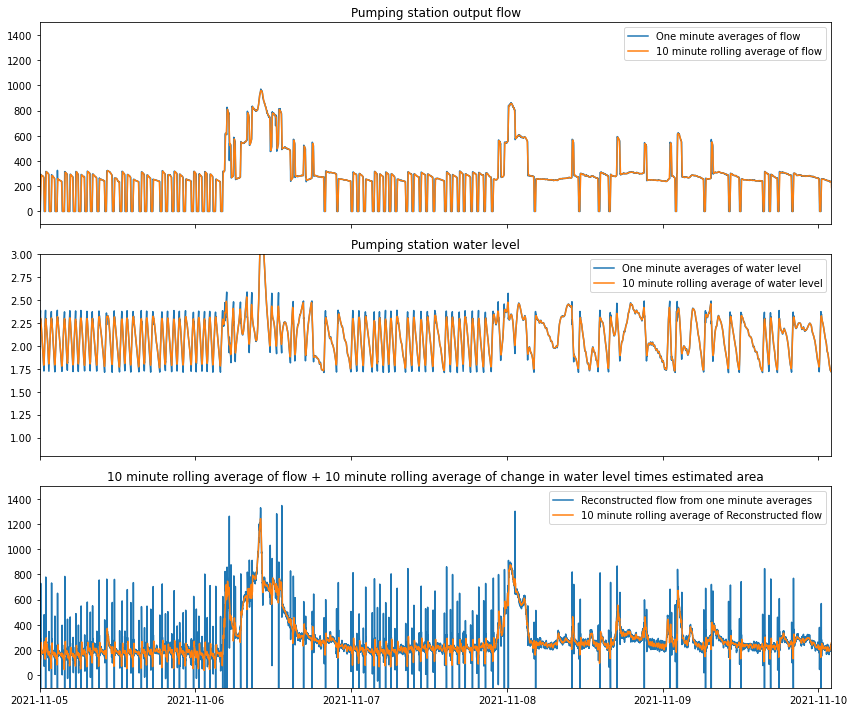

In [772]:
n_roll = 10
tmp_start,tmp_end = datetime.datetime(2021,11,5),datetime.datetime(2021,11,10,2)
fig,ax = plt.subplots(3,1,figsize=(12,10),sharex=True)
ax[0].plot(f,label='One minute averages of flow')
ax[0].plot(f.rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of flow')
# ax[0].set_ylim(-10,190)
ax[0].set_ylim(-100,1500)
ax[0].legend()
ax[0].set_title('Pumping station output flow')

ax[1].plot(h,label='One minute averages of water level')
ax[1].plot(h.rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of water level')
# ax[1].set_ylim(0.8,2.5)
ax[1].set_ylim(0.8,3)
ax[1].legend()
ax[1].set_title(f'Pumping station water level')

ax[2].plot(f + h.diff()*5000,label='Reconstructed flow from one minute averages')
ax[2].plot((f + h.diff()*5000).rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of Reconstructed flow')
ax[2].legend()
ax[2].set_title(f'{n_roll} minute rolling average of flow + {n_roll} minute rolling average of change in water level times estimated area')
# ax[2].set_ylim(-5,210)
ax[2].set_ylim(-100,1500)
plt.xlim(tmp_start,tmp_end)
plt.tight_layout()
plt.show()


# Hourly average comparison

In [773]:

ax[0].set_ylim(-100,1000)

ax[1].set_ylim(0.8,3)

ax[2].set_ylim(-100,1000)

(-100.0, 1000.0)

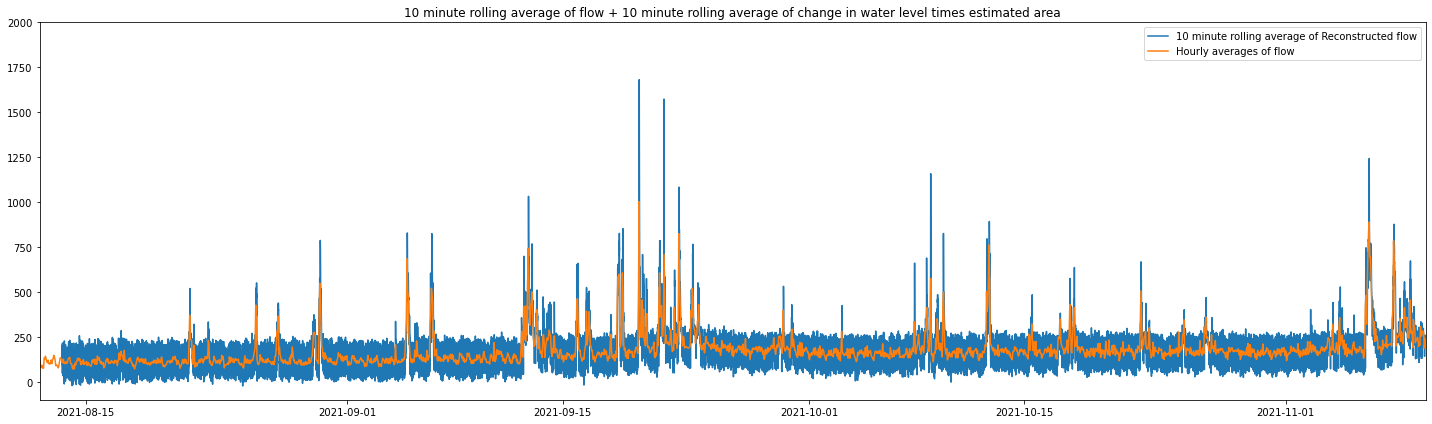

In [774]:
n_roll = 10
tmp_start,tmp_end = datetime.datetime(2021,8,12),datetime.datetime(2021,11,10,2)
fig = plt.figure(figsize=(20,6))


plt.plot((f + h.diff()*5000).rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of Reconstructed flow')
plt.plot(f.resample('1h').mean(),label='Hourly averages of flow')
plt.title(f'{n_roll} minute rolling average of flow + {n_roll} minute rolling average of change in water level times estimated area')
plt.ylim(-100,2000)
plt.xlim(tmp_start,tmp_end)
plt.tight_layout()
plt.legend()
plt.show()


In [775]:
(resids.abs()).dropna().mean()

12.117540237316227

In [776]:
resids = f.resample('1h').mean() - (f + h.diff()*5000).resample('1h').mean()
np.mean(resids**2)

269.52252763284656

In [777]:
resids = f.resample('1h').mean() - (f + h.diff()*5000).rolling(60).mean().resample('1h').mean()
np.mean(resids**2)

940.9549656540332

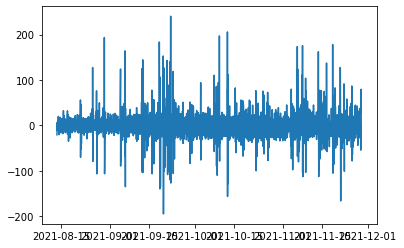

In [778]:
plt.plot(resids)

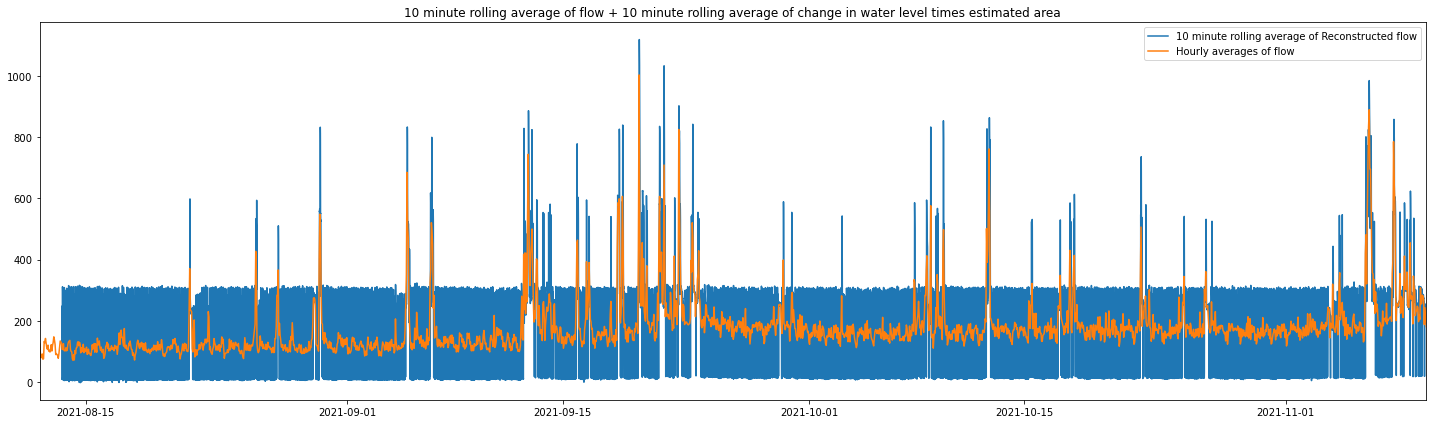

In [779]:
n_roll = 10
tmp_start,tmp_end = datetime.datetime(2021,8,12),datetime.datetime(2021,11,10,2)
tmp_start,tmp_end = datetime.datetime(2021,8,12),datetime.datetime(2021,11,10,2)
fig = plt.figure(figsize=(20,6))


plt.plot((f + h.diff()*486).rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of Reconstructed flow')
plt.plot(f.resample('1h').mean(),label='Hourly averages of flow')
plt.title(f'{n_roll} minute rolling average of flow + {n_roll} minute rolling average of change in water level times estimated area')
# plt.ylim(-5,210)
plt.xlim(tmp_start,tmp_end)
plt.tight_layout()
plt.legend()
plt.show()


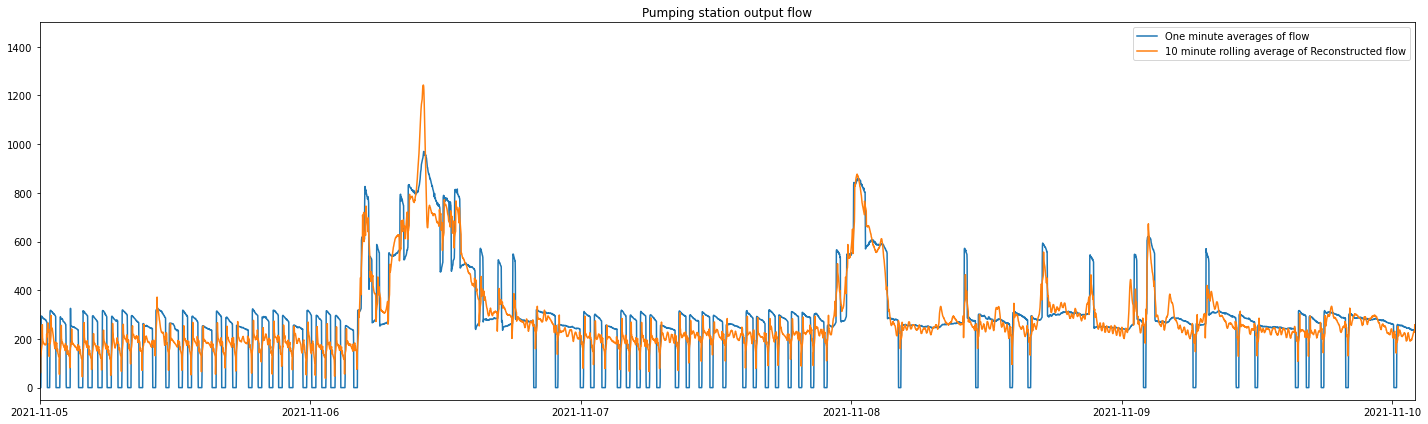

In [780]:
n_roll = 10
tmp_start,tmp_end = datetime.datetime(2021,11,5),datetime.datetime(2021,11,10,2)
# fig,ax = plt.subplots(2,1,figsize=(12,7),sharex=True)
fig = plt.figure(figsize=(20,6))
plt.plot(f,label='One minute averages of flow')
# plt.plot(f.rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of flow')
plt.ylim(-10,190)
plt.legend()
plt.title('Pumping station output flow')

# plt.plot(f + h.diff()*486,label='Reconstructed flow from one minute averages')
plt.plot((f + h.diff()*5000).rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of Reconstructed flow')
# (['Minute avergae flow',f'Minute avergae flow (rolling {n_roll})',f'Minute avergae flow (rolling {n_roll}) plus estimated change in volume (rolling {n_roll})'])
plt.legend()
# plt.title(f'{n_roll} minute rolling average of flow + {n_roll} minute rolling average of change in water level times estimated area')
plt.ylim(-50,1500)
plt.xlim(tmp_start,tmp_end)
plt.tight_layout()
plt.show()


In [679]:
np.mean((h.loc['2021-08-13 11:00:00':].diff(60)*5000).iloc[::60].abs())

743.3738101154197

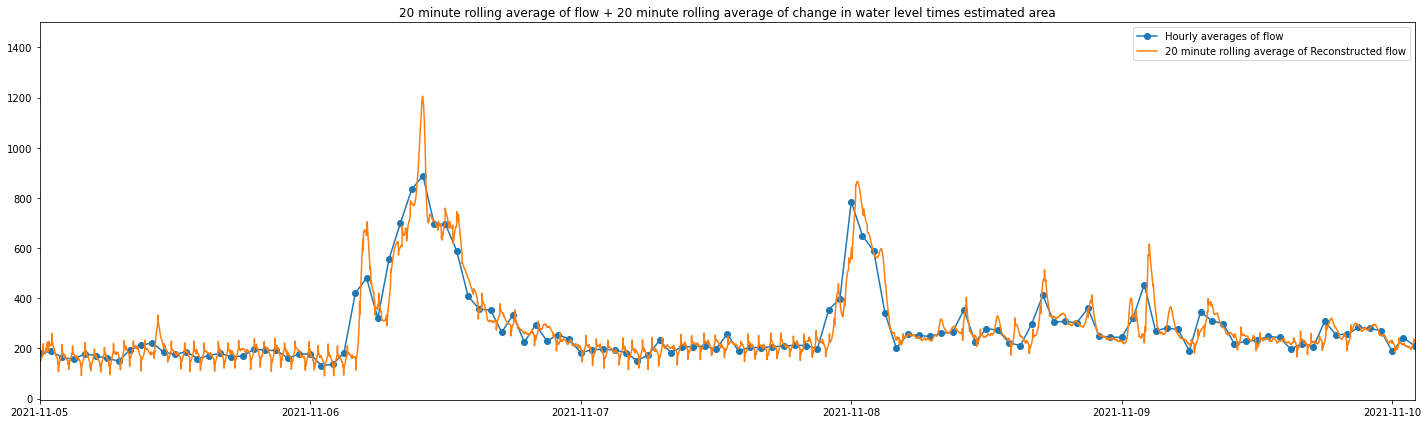

In [781]:
n_roll = 20
tmp_start,tmp_end = datetime.datetime(2021,11,5),datetime.datetime(2021,11,10,2)
fig = plt.figure(figsize=(20,6))
plt.plot(f.resample('1h').mean(),label='Hourly averages of flow',marker='o')


plt.plot((f + h.diff()*5000).rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of Reconstructed flow')
plt.legend()
plt.title(f'{n_roll} minute rolling average of flow + {n_roll} minute rolling average of change in water level times estimated area')
plt.ylim(-5,1500)
plt.xlim(tmp_start,tmp_end)
plt.tight_layout()

plt.show()


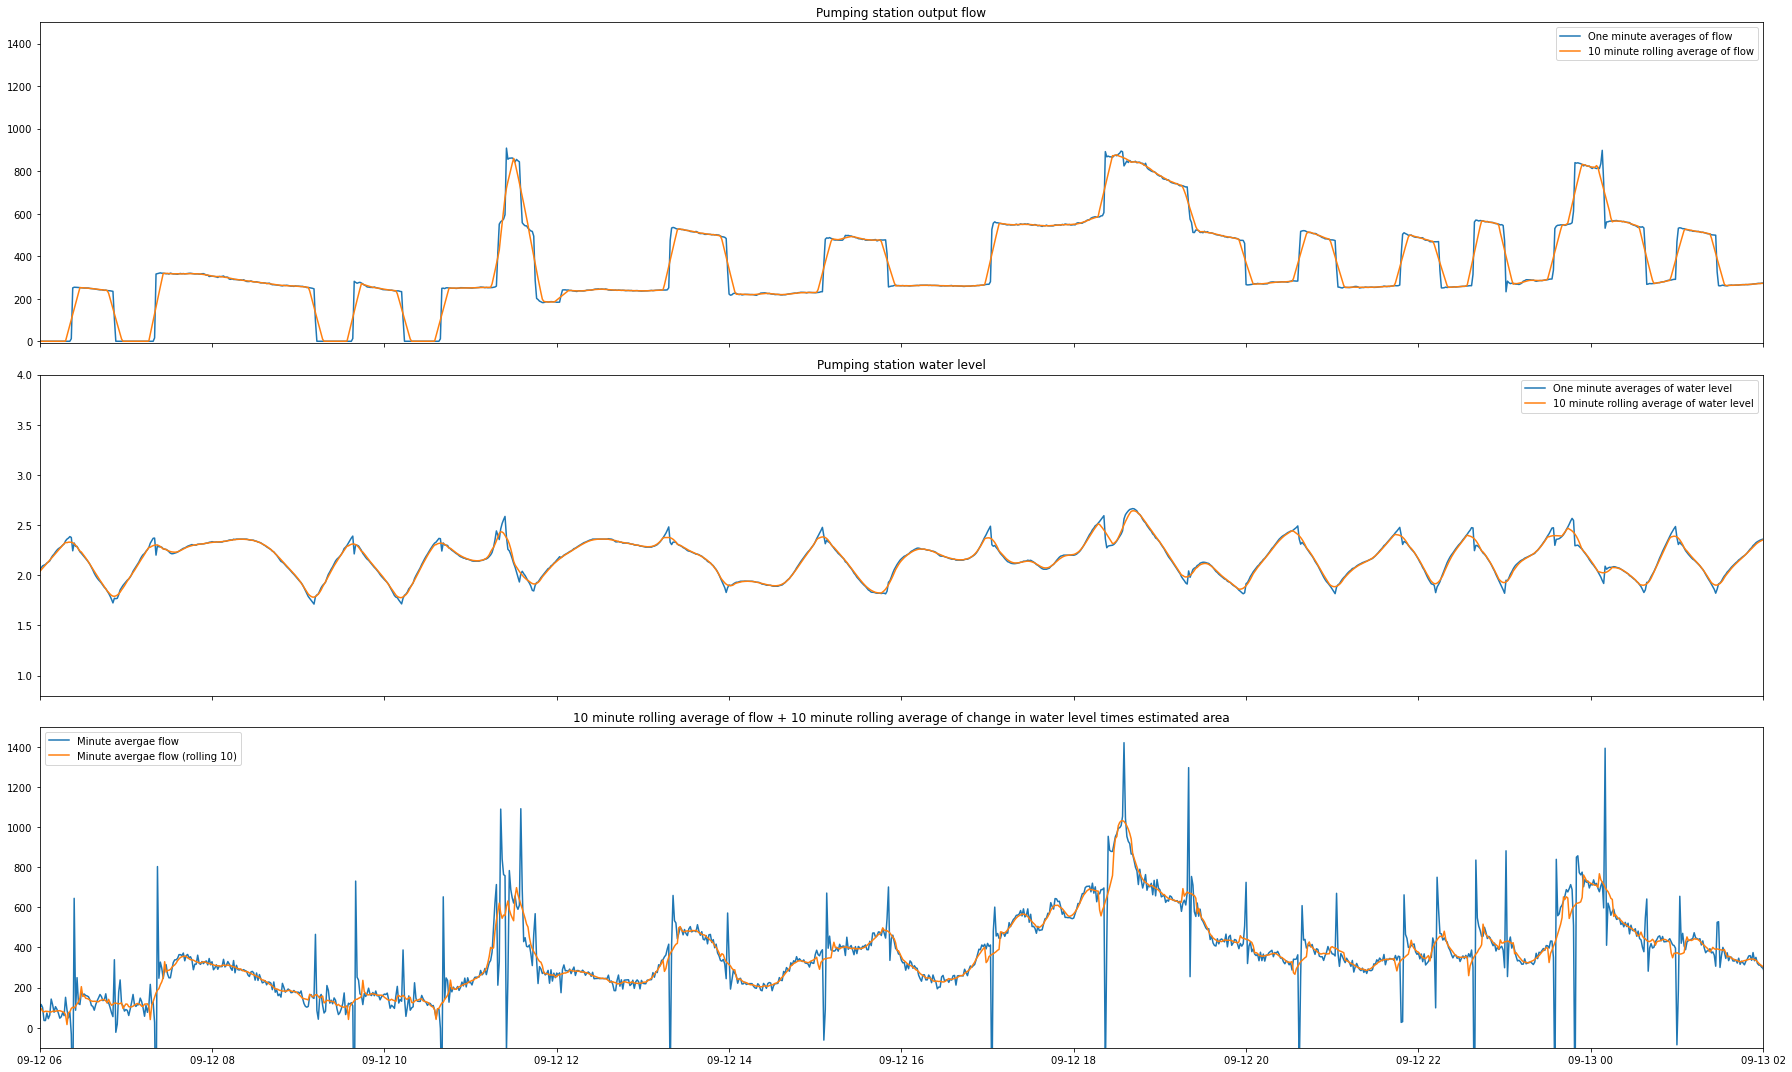

In [782]:
n_roll = 10
tmp_start,tmp_end = datetime.datetime(2021,9,12,6),datetime.datetime(2021,9,13,2)
fig,ax = plt.subplots(3,1,figsize=(25,15),sharex=True)
ax[0].plot(f,label='One minute averages of flow')
ax[0].plot(f.rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of flow')
ax[0].legend()
ax[0].set_ylim(-10,1500)
ax[0].set_title('Pumping station output flow')

ax[1].plot(h,label='One minute averages of water level')
ax[1].plot(h.rolling(n_roll,center=True).mean(),label=f'{n_roll} minute rolling average of water level')
ax[1].legend()
ax[1].set_ylim(0.8,4)
ax[1].set_title(f'Pumping station water level')

ax[2].plot(f + h.diff()*5000)
ax[2].plot((f + h.diff()*5000).rolling(n_roll,center=True).mean())
ax[2].legend(['Minute avergae flow',f'Minute avergae flow (rolling {n_roll})',f'Minute avergae flow (rolling {n_roll}) plus estimated change in volume (rolling {n_roll})'])
ax[2].set_title(f'{n_roll} minute rolling average of flow + {n_roll} minute rolling average of change in water level times estimated area')
ax[2].set_ylim(-100,1500)
plt.xlim(tmp_start,tmp_end)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(25,5))
plt.plot(x)
plt.xlim(datetime.datetime(2021,7,23),datetime.datetime(2021,7,27))
plt.show()